Notebook from kaggle by Ayushman Buragohain

In [1]:
import sys
sys.path.append('../input/timmmodels/pytorch-image-models')

!git clone https://github.com/benihime91/leaf-disease-classification-kaggle.git
!wandb login a74f67fd5fae293e301ea8b6710ee0241f595a63
!pip install torch-summary

Cloning into 'leaf-disease-classification-kaggle'...
remote: Enumerating objects: 312, done.
remote: Counting objects: 100% (312/312), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 689 (delta 195), reused 192 (delta 86), pack-reused 377
Receiving objects: 100% (689/689), 10.80 MiB | 26.39 MiB/s, done.
Resolving deltas: 100% (398/398), done.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import os
import wandb
import albumentations as A

from fastai.vision.all import *
from fastai.callback.wandb import *
from fastai.callback.cutmix import *
from torchsummary import summary

import logging
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)

## Functions

For the sake of simplicity, we will borrow from `timm` lib and `cassava_utils` script

In [3]:
import timm
from cassava_utils import *

In [4]:
SEED        = 42
IDX         = generate_random_id()
OOF_FOLD    = 0
NUM_CLASSES = 5
CSV_PATH    = './leaf-disease-classification-kaggle/data/fold_df.csv'
IMAGE_DIR   = '../input/cassava-leaf-disease-classification/train_images/'
INPUT_DIMS  = 224
MODEL       = 'seresnext50_32x4d'
PROJECT     = 'kaggle-leaf-disease-fastai-runs'
SAVE_NAME   = f"{MODEL}-fold={OOF_FOLD}-{IDX}"

set_seed(SEED, reproducible=True)

Ts = [MODEL, 'ranger', 'mixup', 'label-smoothing']
Ns = f'{MODEL} + ranger + mixup + label-smoothing'
run = wandb.init(project=PROJECT, tags=Ts, notes=Ns,)

wandb: Currently logged in as: ayushman (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Dataset

Our dataset today will be the data from kaggle's [Cassava Leaf Disease Classification](https://www.kaggle.com/c/cassava-leaf-disease-classification).

Goal : using pretrained models , see how well of accuracy we can get in x epochs for the OOF validation dataset.

Pretrained models are loaded mainly from the `timm` library.

In [5]:
data = get_dataset(CSV_PATH, IMAGE_DIR, OOF_FOLD, shuffle=True)
data.head()

,image_id,label,filePath,kfold,is_valid
0,1587173996.jpg,Healthy,../input/cassava-leaf-disease-classification/train_images/1587173996.jpg,2,False
1,404115232.jpg,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/train_images/404115232.jpg,0,True
2,3945098769.jpg,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/train_images/3945098769.jpg,1,False
3,4037735151.jpg,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/train_images/4037735151.jpg,3,False
4,730805822.jpg,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/train_images/730805822.jpg,1,False


In [6]:
TRAIN_AUGS = A.Compose([
    A.OneOf([A.RandomResizedCrop(INPUT_DIMS, INPUT_DIMS), A.CenterCrop(INPUT_DIMS, INPUT_DIMS)], p=0.5),
    A.Resize(INPUT_DIMS, INPUT_DIMS, p=1.0),
    A.OneOf([A.HorizontalFlip(), A.Rotate(60)]),
    A.OneOf([A.Flip(),A.IAAPerspective(), A.ShiftScaleRotate(),], p=0.5),
    A.RandomBrightnessContrast(0.1, 0.1, p=0.5),
    A.OneOf([A.CLAHE(), A.HueSaturationValue(0.2, 0.2, 0.2, p=0.4),], p=0.5),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),])

VALID_AUGS = A.Compose([A.Resize(INPUT_DIMS, INPUT_DIMS, p=1.0)])

ITEM_TFMS  = AlbumentationsTransform(TRAIN_AUGS, VALID_AUGS)
BATCH_TFMS = [Normalize.from_stats(*imagenet_stats)]

dls = get_dataloaders(data, ITEM_TFMS, BATCH_TFMS)

For pretrained models we will working out of Ross Wightman's. Included in this repository is tons of pretrained models for almost every major model in Computer Vision.

## seresnext50_32x4d + MixUp + Ranger + LabelSmoothing

The function below loads a custom model from the `timm` library using the name of the model and prepares it for transfer via fastai `Learner`.

In [7]:
@delegates(Learner)
def timm_learner(dls,m_name:str, cut:int, c:int, state:str=None, init:bool=True,
                 pretrained:bool=True, act:callable=nn.ReLU(inplace=True), **kwargs):
    'create a fast.ai learner instance from timm'
    encoder = timm.create_model(m_name, pretrained=pretrained, )
    
    model   = TransferLearningModel(encoder, num_classes=c, cut=cut, act=act, init=init)
    
    if state is not None: 
        model.load_state_dict(torch.load(state))
    
    learn = Learner(dls, model, **kwargs)
    return learn

In [8]:
cb = [WandbCallback(seed=SEED, log_preds=False, log_model=False)]

learn = timm_learner(dls, MODEL, cut=-2, c=dls.c, pretrained=True, act=nn.ReLU(inplace=True),
                    init=True, metrics=[accuracy], splitter=custom_splitter, opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(), cbs=cb).to_native_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnext50_32x4d_racm-a304a460.pth" to /root/.cache/torch/hub/checkpoints/seresnext50_32x4d_racm-a304a460.pth


In [9]:
_ = summary(learn.model, (3, INPUT_DIMS, INPUT_DIMS), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2048, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         71,952
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         79,632
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         79,632
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         382,496
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         315,936
|    |    └─Bottleneck: 3-6              [-1, 512, 28, 28] 

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=0.0030199517495930195)

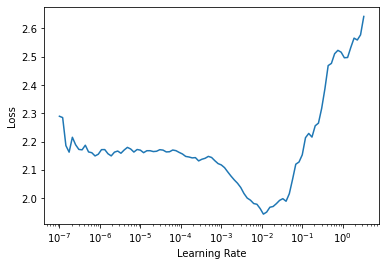

In [10]:
learn.lr_find()

In [12]:
learn.unfreeze()
learn.fit_flat_cos(20, slice(3e-03), pct_start=0, cbs=[MixUp()], wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.187113,0.941469,0.741589,05:05
1,1.021557,0.832659,0.799533,04:41
2,0.965253,0.757764,0.831075,04:41
3,0.939429,0.730568,0.839486,04:44
4,0.902422,0.719232,0.851869,04:52
5,0.892203,0.704844,0.854673,04:52
6,0.868862,0.692308,0.858878,04:52
7,0.877485,0.682675,0.861215,04:51
8,0.855298,0.678079,0.861916,04:49
9,0.850574,0.679800,0.867757,04:53


In [13]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [14]:
learn = learn.load('stage-1')
learn.unfreeze()

SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=1.3182567499825382e-06)

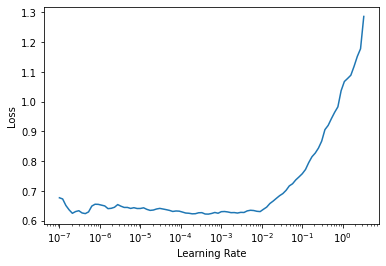

In [15]:
learn.lr_find()

In [16]:
learn.fit_flat_cos(10, slice(8e-04), pct_start=0, cbs=[MixUp(0.2)], wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.742786,0.677924,0.868925,05:10
1,0.736744,0.676156,0.870093,05:01
2,0.737166,0.679806,0.870794,04:57
3,0.722289,0.684723,0.867056,04:59
4,0.734866,0.680924,0.871028,04:57
5,0.733594,0.683871,0.873598,04:56
6,0.715604,0.684752,0.873365,04:57
7,0.722567,0.683517,0.871963,04:57
8,0.705521,0.684698,0.874299,05:06
9,0.714270,0.684411,0.868458,05:12


In [17]:
learn.save('stage-2')

Path('models/stage-2.pth')

Let's upload the models weights to `wandb`

In [18]:
learn = learn.load('stage-2')
learn.unfreeze()
learn = learn.to_native_fp32()

In [19]:
save_dir = f"/kaggle/working/{SAVE_NAME}.pt"
torch.save(learn.model.state_dict(), save_dir)
wandb.save(save_dir)
wandb.finish()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


epoch,30
train_loss,0.71427
raw_loss,0.88237
wd_0,0.1
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,0.0
beta_0,0.0
wd_1,0.1
sqr_mom_1,0.99


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,▇█▅▃▄▅▂▃▃▄▂▃▃▃▃▃▂▂▂▃▂▃▂▃▃▂▄▁▁▂▂▂▂▂▂▃▁▂▂▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,█████▇▇▇▆▆▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁▃▃▃▂▂▂▂▂▁▁▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
